# Collagen Quantification Mouse

In [1]:
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

from tqdm import tqdm
import os
import matplotlib.pyplot as plt

import histomicstk as htk

import numpy as np
from skimage.transform import resize
from scipy import ndimage
from skimage.filters import threshold_multiotsu

import multiprocessing
from multiprocessing import Pool
from threading import Lock

import pandas as pd

/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/cupy/_environment.py:445: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


## Load Data

In [2]:
IMAGE_PATH = "/media/Data3/Jacky/Data/Dafni_lung_slide_scans/Mouse/Mouse_female2-007_w16/s1/Mouse-week16-Fem2-007-PSR_s1.czi"
OUTPUT_DIR = "/media/Data3/Jacky/Data/Dafni_lung_slide_scans/Mouse/Mouse_female2-007_w16/s1"

os.makedirs(OUTPUT_DIR,exist_ok=True)

In [3]:
image = AICSImage(IMAGE_PATH)
print(image.dims)

<Dimensions [T: 1, C: 1, Z: 1, Y: 33565, X: 44725, S: 3]>


In [4]:
image_dask = image.get_image_dask_data("XYS")
image_dask

dask.array<transpose, shape=(44725, 33565, 3), dtype=uint8, chunksize=(6688, 6688, 3), chunktype=numpy.ndarray>

## Colour Deconvolution for the PSF Purified Channel

### Stain Vector from QuPath

In [5]:
# mouse
stain_color_map = {
    'PSR': [0.496,0.712,0.497],
    'FG': [0.802,0.201,0.562],
    'Residual': [-0.525,-0.21,0.825]
}
background = [207,209,206]

### Perform Stain Vector Separation

In [6]:
# specify stains of input image
stains = stain_color_map.keys()

In [7]:
def tiled_deconv_helper(image,roi,W):
    imDeconvolved_batch = htk.preprocessing.color_deconvolution.color_deconvolution(image, W)
    return {"image_tile": imDeconvolved_batch.Stains, "roi":roi}

In [8]:
def stain_vector_separation_large(image, stain_color_map, stains, batch_size=2048, threads=0):
    print('stain_color_map:', stain_color_map, sep='\n')

    # create stain matrix
    W = np.array([stain_color_map[st] for st in stains]).T

    # perform standard color deconvolution
    imDeconvolved = np.zeros_like(image)

    n_rows, n_cols = image.shape[0:2]

    if threads < 2:
        n_row_batches = (n_rows+batch_size-1)//batch_size
        n_col_batches = (n_cols+batch_size-1)//batch_size

        # create progress bar:
        pbar = tqdm(total=n_row_batches*n_col_batches, desc="Tile deconvolving")

        # this section can be parallelized
        for row_start in range(0,n_rows, batch_size):
            for col_start in range(0,n_cols, batch_size):
                row_end = min(row_start+batch_size, n_rows)
                col_end = min(col_start+batch_size, n_cols)

                # extract a batch from the image tile
                batch = image[row_start:row_end, col_start:col_end, :]

                # tile deconvolution
                imDeconvolved_batch = htk.preprocessing.color_deconvolution.color_deconvolution(batch, W)
                
                # update the output image
                imDeconvolved[row_start:row_end, col_start:col_end] = imDeconvolved_batch.Stains

                pbar.update(1)
        
        pbar.close()
    else:
        region_to_process = []
        for row_start in range(0,n_rows, batch_size):
            for col_start in range(0,n_cols, batch_size):
                row_end = min(row_start+batch_size, n_rows)
                col_end = min(col_start+batch_size, n_cols)
                region_to_process.append({"tile": image[row_start:row_end,col_start:col_end,:],"roi":(row_start,row_end,col_start,col_end)})

        print("{} tiles to process".format(len(region_to_process)))
        pbar = tqdm(desc="Tiled color deconvolution in parallel",total=len(region_to_process))
        pbar.clear()

        mutex = Lock()

        def callback_fn(res):
            pbar.update(1)
            row_start,row_end,col_start,col_end = res["roi"]
            img_tile = res["image_tile"]
            with mutex:
                imDeconvolved[row_start:row_end,col_start:col_end,:] = img_tile

        def callback_err(err):
            print(err)

        # Create a Pool with the specified number of processes
        pool = Pool(threads) # control number of threads to limit memory consumption
        for region in region_to_process:
            tile = region["tile"]
            roi = region["roi"]
            pool.apply_async(tiled_deconv_helper, (tile,roi,W), callback=callback_fn, error_callback=callback_err)
        pool.close()
        pool.join()
        pbar.close()

    return imDeconvolved

In [9]:
# Load image 
print("Loading image...")
image_np = image_dask.compute()

Loading image...


In [10]:
# Color deconvolution
print("Performing color deconvolution")
imDeconvolved = stain_vector_separation_large(image_np, stain_color_map, stains, batch_size=4096,threads=multiprocessing.cpu_count())
# imDeconvolved = stain_vector_separation_large(image_np, stain_color_map, stains, batch_size=4096,threads=4)

Performing color deconvolution
stain_color_map:
{'PSR': [0.496, 0.712, 0.497], 'FG': [0.802, 0.201, 0.562], 'Residual': [-0.525, -0.21, 0.825]}
99 tiles to process


Tiled color deconvolution in parallel: 100%|██████████| 99/99 [00:42<00:00,  2.34it/s]


In [11]:
# save the deconvolved image
image_basename = IMAGE_PATH.split(os.sep)[-1].split(".")[0]

outpath = os.path.join(OUTPUT_DIR,"{}_color_deconv.tif".format(image_basename))
writer = OmeTiffWriter()
# only save PSR channel
writer.save(imDeconvolved.T[0,:,:],outpath,
                   physical_pixel_sizes=image.physical_pixel_sizes,
                   dim_order="YX",
                   )

## Tissue Mask

In [12]:
psr_image = imDeconvolved[:,:,0]

In [13]:
# Down sample for quick computation
psr_image_subsampled = psr_image[::10,::10]

In [14]:
# otsu thresholding
thresholds = threshold_multiotsu(psr_image_subsampled,classes=3)

# Using the threshold values, we generate the three regions.
regions = np.digitize(psr_image_subsampled, bins=thresholds)

tissue_mask_subsampled = regions
tissue_mask_subsampled[tissue_mask_subsampled!=1] = 0

filled_tissue_mask_subsampled = tissue_mask_subsampled
filled_tissue_mask_subsampled = ndimage.binary_closing(filled_tissue_mask_subsampled, structure=np.ones((25,25))).astype(int)
filled_tissue_mask_subsampled = ndimage.binary_fill_holes(filled_tissue_mask_subsampled, structure=np.ones((5,5))).astype(int)

In [33]:
# rescale mask back to original dim
tissue_mask = resize(tissue_mask_subsampled.astype(bool), psr_image.shape,anti_aliasing=False)
filled_tissue_mask = resize(filled_tissue_mask_subsampled.astype(bool), psr_image.shape,anti_aliasing=False)


In [16]:
# mask the original data
psr_image_filtered = np.copy(psr_image)
psr_image_filtered[filled_tissue_mask==0] = 0

psr_image_filtered_subsampled = psr_image_filtered[::10,::10]

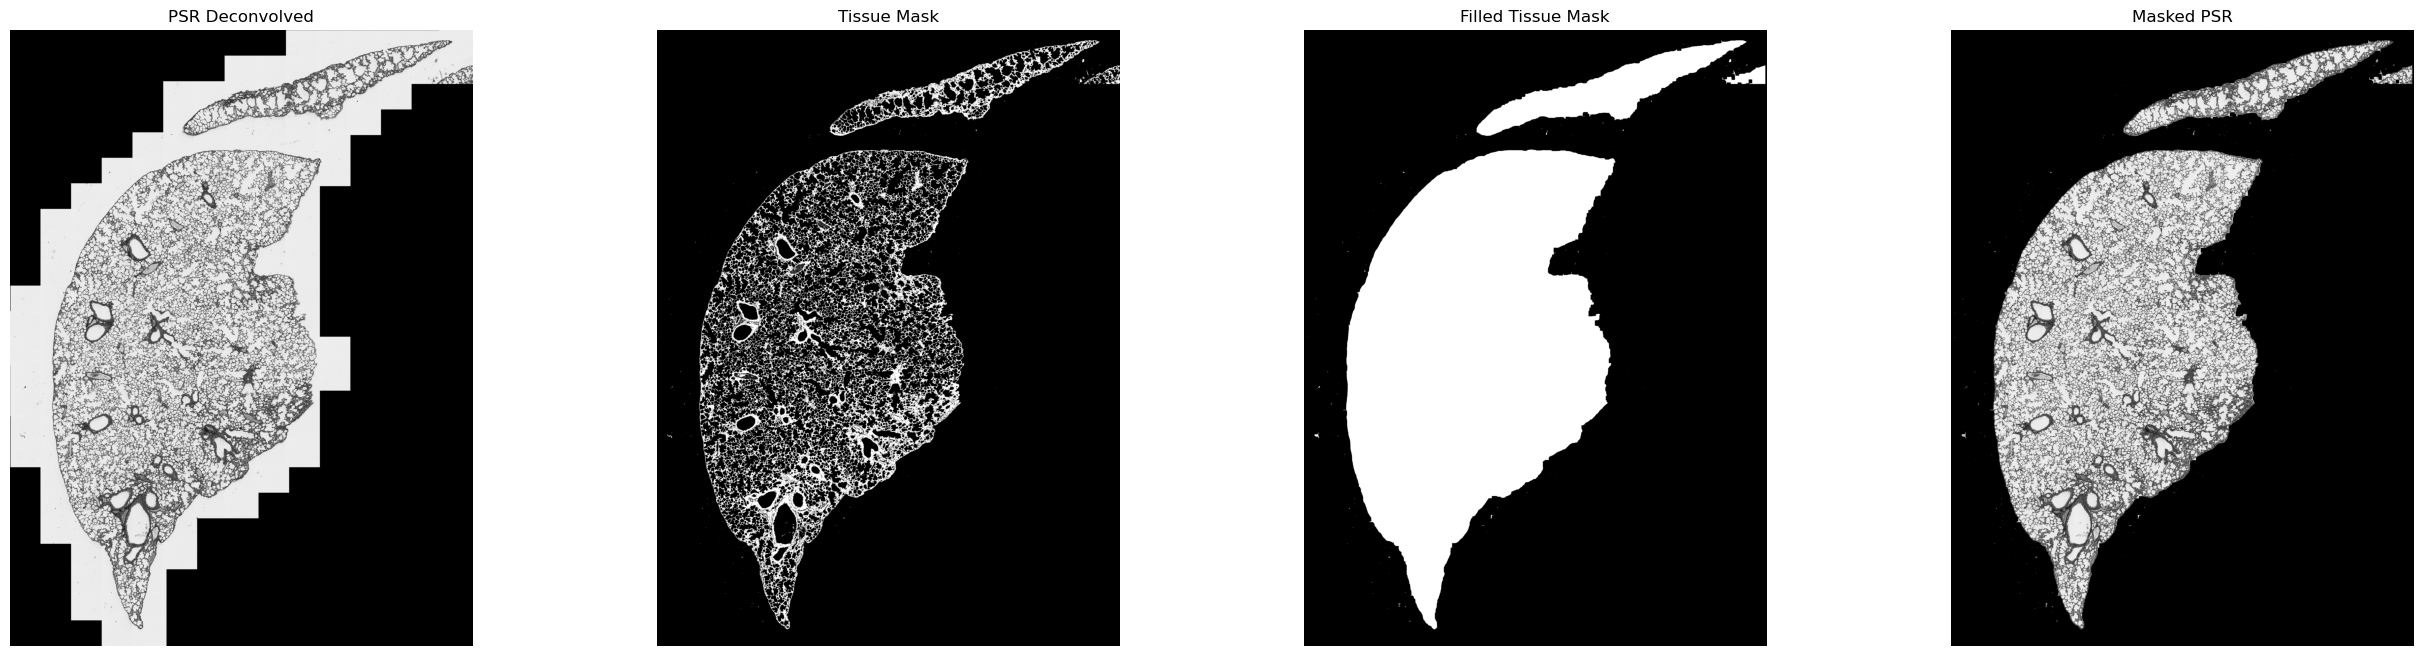

In [17]:
# plot the data
fig, axs = plt.subplots(1,4,figsize=(32,8))
axs[0].set_title("PSR Deconvolved")
axIm = axs[0].imshow(psr_image_subsampled,cmap="gray")
axs[0].set_axis_off()
axs[0].set_aspect('equal')
axs[0].autoscale(False)

axs[1].set_title("Tissue Mask")
axIm = axs[1].imshow(tissue_mask_subsampled,cmap="gray")
axs[1].set_axis_off()
axs[1].set_aspect('equal')
axs[1].autoscale(False)

axs[2].set_title("Filled Tissue Mask")
axIm = axs[2].imshow(filled_tissue_mask_subsampled,cmap="gray")
axs[2].set_axis_off()
axs[2].set_aspect('equal')
axs[2].autoscale(False)

axs[3].set_title("Masked PSR")
axIm = axs[3].imshow(psr_image_filtered_subsampled,cmap="gray")
axs[3].set_axis_off()
axs[3].set_aspect('equal')
axs[3].autoscale(False)

## Get Threshold Value for the Masked Tissue

In [18]:
# # otsu thresholding
# thresholds = threshold_multiotsu(psr_image_filtered_subsampled,classes=4)

# collagen = np.copy(psr_image_filtered)
# # Using the threshold values, we generate the three regions.
# regions = np.digitize(collagen, bins=thresholds)
# collagen = regions
# collagen[collagen!=1] = 0
# collagen = collagen.astype(np.uint8)

PERCENTILE = 5

psr_image_filtered_lin = psr_image_filtered.ravel()
psr_image_filtered_lin = psr_image_filtered_lin[psr_image_filtered_lin != 0]

percentile = np.percentile(psr_image_filtered_lin,PERCENTILE)
print("percentile:", percentile)

collagen = np.zeros_like(psr_image_filtered,dtype=np.uint8)
collagen[(psr_image_filtered>0) & (psr_image_filtered<percentile)] = 1

percentile: 49.0


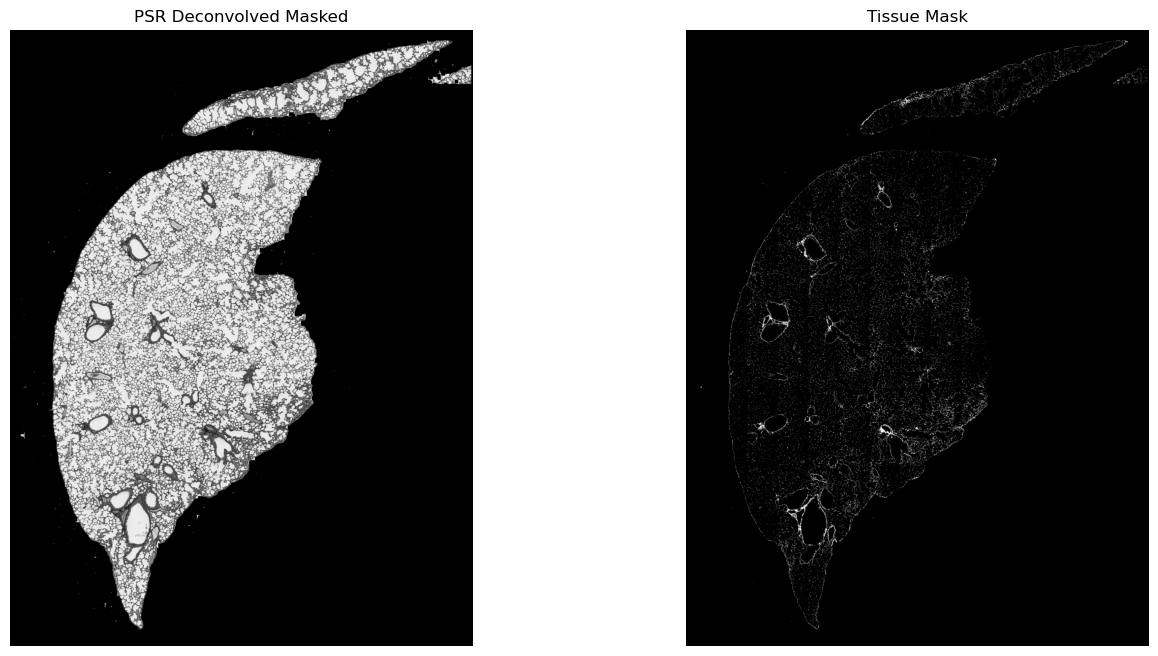

In [19]:
# plot the data
fig, axs = plt.subplots(1,2,figsize=(16,8))
axs[0].set_title("PSR Deconvolved Masked")
axIm = axs[0].imshow(psr_image_filtered_subsampled,cmap="gray")
axs[0].set_axis_off()
axs[0].set_aspect('equal')
axs[0].autoscale(False)

axs[1].set_title("Tissue Mask")
axIm = axs[1].imshow(collagen[::10,::10],cmap="gray")
axs[1].set_axis_off()
axs[1].set_aspect('equal')
axs[1].autoscale(False)

## Zoom in the check the segmetnation result

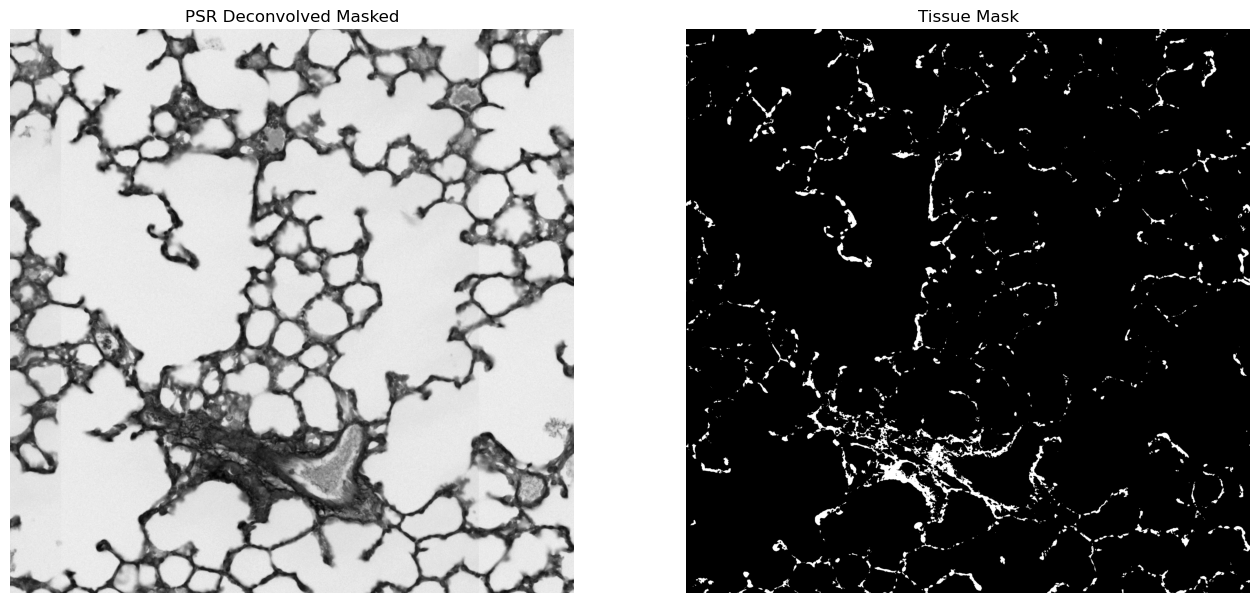

In [20]:
SIZE = 3000

size_off = SIZE//2

psr_image_filtered_crop = psr_image_filtered[
    psr_image_filtered.shape[0]//2-size_off:psr_image_filtered.shape[0]//2+size_off,
    psr_image_filtered.shape[1]//2-size_off:psr_image_filtered.shape[1]//2+size_off,
    ]

collagen_crop = collagen[
    collagen.shape[0]//2-size_off:collagen.shape[0]//2+size_off,
    collagen.shape[1]//2-size_off:collagen.shape[1]//2+size_off,
    ]

# plot the data
fig, axs = plt.subplots(1,2,figsize=(16,8))
axs[0].set_title("PSR Deconvolved Masked")
axIm = axs[0].imshow(psr_image_filtered_crop,cmap="gray")
axs[0].set_axis_off()
axs[0].set_aspect('equal')
axs[0].autoscale(False)

axs[1].set_title("Tissue Mask")
axIm = axs[1].imshow(collagen_crop,cmap="gray")
axs[1].set_axis_off()
axs[1].set_aspect('equal')
axs[1].autoscale(False)

## Area Quantification

In [38]:
pixel_size = image.physical_pixel_sizes.X*image.physical_pixel_sizes.Y

collagen_area = np.sum(collagen)*pixel_size
tissue_area = np.sum(tissue_mask)*pixel_size
filled_tissue_area = np.sum(filled_tissue_mask)*pixel_size

res = {
    "collagen (um^2)": collagen_area,
    "tissue (um^2)": tissue_area,
    "filled_tissue (um^2)": filled_tissue_area,
    "collagen vs tissue (%)": collagen_area/tissue_area*100,
    "collagen vs filled tissue (%)": collagen_area/filled_tissue_area*100,
    }

res = pd.Series(res)
res.to_csv(os.path.join(OUTPUT_DIR,"res.csv"))
res

collagen (um^2)                  6.331172e+05
tissue (um^2)                    4.648979e+06
filled_tissue (um^2)             1.387845e+07
collagen vs tissue (%)           1.361841e+01
collagen vs filled tissue (%)    4.561872e+00
dtype: float64

## Save Result

In [37]:
# save the deconvolved image
image_basename = IMAGE_PATH.split(os.sep)[-1].split(".")[0]

outpath = os.path.join(OUTPUT_DIR,"{}_label_collagen.tif".format(image_basename))
writer = OmeTiffWriter()
# only save PSR channel
collagen_ = collagen*255
writer.save(collagen_.astype(np.uint8).T,outpath,
            physical_pixel_sizes=image.physical_pixel_sizes,
            dim_order="YX",
            )

outpath = os.path.join(OUTPUT_DIR,"{}_label_tissue.tif".format(image_basename))
writer = OmeTiffWriter()
# only save PSR channel
tissue_mask_ = tissue_mask*255
writer.save(tissue_mask_.astype(np.uint8).T,outpath,
            physical_pixel_sizes=image.physical_pixel_sizes,
            dim_order="YX",
)

outpath = os.path.join(OUTPUT_DIR,"{}_label_filled_tissue.tif".format(image_basename))
writer = OmeTiffWriter()
# only save PSR channel
filled_tissue_mask_ = filled_tissue_mask*255
writer.save(filled_tissue_mask_.astype(np.uint8).T,outpath,
            physical_pixel_sizes=image.physical_pixel_sizes,
            dim_order="YX",
)